Install all requirements

In [1]:
!pip3 install torch==1.9.0+cu111 torchvision==0.10.0+cu111 torchaudio===0.9.0 -f https://download.pytorch.org/whl/torch_stable.html
!pip install nuscenes-devkit
!pip install wandb

# Fix error : libGL.so.1: cannot open shared object file: No such file or directory
!apt-get update
!apt install -y libgl1-mesa-glx

Looking in links: https://download.pytorch.org/whl/torch_stable.html
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Hit:1 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]      
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]    
Ign:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:5 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]    
Get:6 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 Packages [2658 kB]
Ign:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1

In [1]:
import torch

print(torch.cuda.is_available())

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on ', device)
print(f"Device count: {torch.cuda.device_count()}")

True
Running on  cuda:0
Device count: 1


In [5]:
NPY_DATASET_PATH = './NpyDataset/Multiagent/'
#NPY_DATASET_PATH = './'

TRAJECTORY_SET_PATH = './Dataset/'
#TRAJECTORY_SET_PATH = './'

VALIDATION_SAMPLES_PATH = "./CustomDataSplit/validation_samples.json"
#VALIDATION_SAMPLES_PATH = "./validation_samples.json"

Unzip nessesary files

In [8]:
import os
import zipfile
import subprocess

def unzipFile(pathToZip, pathToOut):
    unzip = ['unzip', '-o', pathToZip, '-d', pathToOut]
    p = subprocess.call(unzip)

In [ ]:
unzipFile(f'./prediction_trajectory_sets.zip', CURRENT_PATH)
unzipFile(f'./repVgg.zip', CURRENT_PATH)

In [25]:
unzipFile(f'./multiagent_validation_features_6k.zip', CURRENT_PATH)
unzipFile(f'./multiagent_train_features_24k.zip', CURRENT_PATH)

Load files

In [6]:
import json

def json_loader(path):
    with open(VALIDATION_SAMPLES_PATH, "r") as read_file:
        result_list = json.load(read_file)
        
    return result_list

In [7]:
validation_samples = json_loader(VALIDATION_SAMPLES_PATH)
len(validation_samples)

6200

In [67]:
import numpy as np

# Npy dataset

train_features = np.load(f'{NPY_DATASET_PATH}multiagent_train_features_24k.npy')
train_states = np.load(f'{NPY_DATASET_PATH}multiagent_train_states_24k.npy')
train_labels = np.load(f'{NPY_DATASET_PATH}multiagent_train_labels_24k.npy')

validation_features = np.load(f'{NPY_DATASET_PATH}multiagent_validation_features_6k.npy')
validation_states = np.load(f'{NPY_DATASET_PATH}multiagent_validation_states_6k.npy')
validation_labels = np.load(f'{NPY_DATASET_PATH}multiagent_validation_labels_6k.npy')

In [69]:
len(train_features), len(train_states), len(train_labels)

(6200, 6200, 6200)

In [70]:
len(validation_features), len(validation_states), len(validation_labels)

(6200, 6200, 6200)

In [16]:
import pickle

#PATH_TO_EPSILON_8_SET = f"{TRAJECTORY_SET_PATH}Dataset/prediction_trajectory_sets/epsilon_8.pkl"
#PATH_TO_EPSILON_8_SET = f"{TRAJECTORY_SET_PATH}prediction_trajectory_sets/epsilon_8.pkl"
PATH_TO_EPSILON_2_SET = f"{TRAJECTORY_SET_PATH}prediction_trajectory_sets/epsilon_2.pkl"

trajectories_set = pickle.load(open(PATH_TO_EPSILON_2_SET, 'rb'))
trajectories_set = torch.Tensor(trajectories_set)

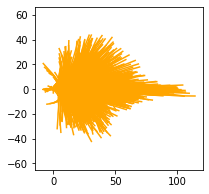

2206

In [17]:
import matplotlib.pyplot as plt

def PlotGeneratedTrajectories(future_list):
  plt.figure(figsize=(3, 3))

  for future in future_list:
    plt.plot(future[:, 1], -future[:, 0], c='orange')

  # Keep aspect ratio of axis
  plt.axis('equal')
  plt.show()

PlotGeneratedTrajectories(trajectories_set)
len(trajectories_set)

Wandb config

In [12]:
import wandb

wandb.init(
    #project='CoverNet',
    project='testing',
    entity='techtoker',
    config={    
        "epoch": 35,
        "batch_size": 32,
        # Trajectory set 8: 64 ;Trajectory set 2 : 2206
        "num_modes": 2206,
        "lr":5e-4,
        "notes": "v0.1 : Multiagent model: train: 20k cars, 3600 peds, 800 motobikes; val: 5k cars 1k peds, 200 motobikes"
    })

config = wandb.config

wandb: Currently logged in as: techtoker (use `wandb login --relogin` to force relogin)


Dataset

In [74]:
from torch.utils.data import DataLoader, Dataset

import numpy as np
from typing import List

class NuscenesDataset(Dataset):
    def __init__(self, features: List[str], states: List[str], labels: List[str]):
        self.features = features
        self.states = states
        self.labels = labels

    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, index: int):

        image = self.features[index].reshape((500, 500, 3))
        image = torch.Tensor(image).permute(2, 0, 1)
        
        agent_state_vector = torch.Tensor(self.states[index])
        ground_truth = self.labels[index].reshape((12, 2))

        # Convert to [batch_size, 1, 12, 2]
        # Because loss function need that format
        ground_truth = np.expand_dims(ground_truth, 0)

        return image, agent_state_vector, ground_truth

In [75]:
train_ds = NuscenesDataset(train_features, train_states, train_labels)
train_dl = DataLoader(train_ds, batch_size=config.batch_size, shuffle=True)

validation_ds = NuscenesDataset(validation_features, validation_states, validation_labels)
validation_dl = DataLoader(train_ds, batch_size=config.batch_size * 2)

In [76]:
image, state, ground_truth = next(iter(train_dl))
print(image.size())
print(state.size())
print(ground_truth.size())

torch.Size([32, 3, 500, 500])
torch.Size([32, 3])
torch.Size([32, 1, 12, 2])


In [19]:
# Build-in backbone ResNet
#from nuscenes.prediction.models.backbone import ResNetBackbone

# Torchvision ResNet
#import torchvision.models as models

# RepVGG
from repVgg.repVggBackbone import RepVGGBackbone

# Torchvision backbone
# backbone = models.resnext50_32x4d(pretrained=True)

# Build-in backbone
#backbone = ResNetBackbone('resnet50')

# RepVGG

backbone = RepVGGBackbone()

RepVGG Block, identity =  None
RepVGG Block, identity =  None
RepVGG Block, identity =  BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  None
RepVGG Block, identity =  BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  None
RepVGG Block, identity =  BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =

In [20]:
# Reshape last layer as 2048 (not 1000)
import torch.nn as nn

backbone.linear = nn.Linear(in_features=1280, out_features=2048, bias=True)
print(backbone)

RepVGGBackbone(
  (backbone): RepVGG(
    (stage0): RepVGGBlock(
      (nonlinearity): ReLU()
      (se): Identity()
      (rbr_dense): Sequential(
        (conv): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (rbr_1x1): Sequential(
        (conv): Conv2d(3, 48, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (stage1): Sequential(
      (0): RepVGGBlock(
        (nonlinearity): ReLU()
        (se): Identity()
        (rbr_dense): Sequential(
          (conv): Conv2d(48, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (rbr_1x1): Sequential(
          (conv): Conv2d(48, 48, kernel_size=(1, 1), stride=(2, 2), bia

In [21]:
# # Set backbone to non-trainable

# def set_parameter_requires_grad(model):
#     for param in model.parameters():
#         param.requires_grad = False
        
# set_parameter_requires_grad(backbone)

In [22]:
from torch.optim import SGD
from nuscenes.prediction.models.covernet import CoverNet, ConstantLatticeLoss

model = CoverNet(backbone, num_modes=config.num_modes)
model = model.to(device)

loss_function = ConstantLatticeLoss(trajectories_set)

In [23]:
# Pass to optimizer only params with requires_grad
params_to_update = []

for name,param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

optimizer = SGD(params_to_update, lr=config.lr, momentum=0.9, weight_decay=5e-4)

	 backbone.backbone.stage0.rbr_dense.conv.weight
	 backbone.backbone.stage0.rbr_dense.bn.weight
	 backbone.backbone.stage0.rbr_dense.bn.bias
	 backbone.backbone.stage0.rbr_1x1.conv.weight
	 backbone.backbone.stage0.rbr_1x1.bn.weight
	 backbone.backbone.stage0.rbr_1x1.bn.bias
	 backbone.backbone.stage1.0.rbr_dense.conv.weight
	 backbone.backbone.stage1.0.rbr_dense.bn.weight
	 backbone.backbone.stage1.0.rbr_dense.bn.bias
	 backbone.backbone.stage1.0.rbr_1x1.conv.weight
	 backbone.backbone.stage1.0.rbr_1x1.bn.weight
	 backbone.backbone.stage1.0.rbr_1x1.bn.bias
	 backbone.backbone.stage1.1.rbr_identity.weight
	 backbone.backbone.stage1.1.rbr_identity.bias
	 backbone.backbone.stage1.1.rbr_dense.conv.weight
	 backbone.backbone.stage1.1.rbr_dense.bn.weight
	 backbone.backbone.stage1.1.rbr_dense.bn.bias
	 backbone.backbone.stage1.1.rbr_1x1.conv.weight
	 backbone.backbone.stage1.1.rbr_1x1.bn.weight
	 backbone.backbone.stage1.1.rbr_1x1.bn.bias
	 backbone.backbone.stage2.0.rbr_dense.conv.weight
	

In [24]:
import copy

current_epoch = 0
best_model_wts = copy.deepcopy(model.state_dict())

In [25]:
from tqdm import tqdm

trajectories_set_np = trajectories_set.cpu().numpy()

In [26]:
import nuscenes.eval.prediction.metrics as metrics
from collections import defaultdict
from typing import List, Dict, Any


def GetPrediction(instance_token, sample_token, img, state):
    img = torch.Tensor(img.reshape((500, 500, 3))).permute(2, 0, 1).unsqueeze(0)
    img = img.to(device)

    state = torch.Tensor(np.array([state])).to(device)
    state = state.to(device)

    logits = model(img, state)
    mode_probabilities = np.array([logits.cpu().detach().numpy()[0]])[0]

    # ВЗЯТЬ НЕ БОЛЕЕ 25 САМЫХ ПОПУЛЯРНЫХ; Иначе - ошибка Error: prediction contains more than 25 modes.
    sorted_logits_indexes = logits.cpu().argsort(descending=True)
    sorted_trajectories = trajectories_set_np[sorted_logits_indexes][0]

    top_25_trajectories = sorted_trajectories[:25]
    top_25_probabilities = mode_probabilities[:25]

    # Create prediction object
    prediction = metrics.Prediction(instance_token, sample_token, top_25_trajectories, top_25_probabilities)

    return prediction


def GetMetrics(model, samples, features, states, ground_truth):
    # Define metrics function and container
    metric_functions = [metrics.MinFDEK([1], aggregators=[metrics.RowMean()]),
                        metrics.MinADEK([5, 10], aggregators=[metrics.RowMean()]),
                        metrics.MissRateTopK([5, 10], tolerance=2, aggregators=[metrics.RowMean()])]

    num_predictions = len(features) # Amount of prediction rows (equals of len of validation)

    metrics_container = {metric.name: np.zeros((num_predictions, metric.shape)) for metric in metric_functions}
    
    # Prediction loop
    for idx, x in enumerate(tqdm(features)):
        
        # Make prediction
        instance_tkn, sample_tkn = samples[idx].split("_")
        prediction = GetPrediction(instance_tkn, sample_tkn, features[idx], states[idx])
        
        # Get ground_truth
        gt = ground_truth[idx].reshape((12, 2))

        # Calculate metrics
        for metric in metric_functions:
            metrics_container[metric.name][idx] = metric(gt, prediction)
    
    # Metrics aggregations
    aggregations: Dict[str, Dict[str, List[float]]] = defaultdict(dict)

    for metric in metric_functions:
        for agg in metric.aggregators:
            aggregations[metric.name][agg.name] = agg(metrics_container[metric.name])

    return aggregations

In [27]:
from tqdm import tqdm
import time

def loss_batch(model, loss_func, img, state_vec, ground_truth, opt=None):
    img = img.to(device)
    state_vec = state_vec.to(device)
    ground_truth = ground_truth.to(device)
    
    predicted_logits = model(img, state_vec)
    loss = loss_func(predicted_logits, ground_truth)

    # For validation optimizer is None, thus we dont perform backprop
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    # Return losses and amount of items
    #print(f"{loss.item()}; {len(img)}")
    return loss.item(), len(img)


def train_step(model, train_dl, loss_func, opt):
    model.train()

    losses = []
    nums = []
    for img, state_vec, gt in tqdm(train_dl):
        loss, num = loss_batch(model, loss_func, img, state_vec, gt, opt)
        losses.append(loss)
        nums.append(num)

    # Calculate train loss
    train_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
    return train_loss


def validation_step(model, valid_dl, loss_func):
    print("Validation step")
    model.eval()

    with torch.no_grad():
        losses = []
        nums = []
        for img, state_vec, gt in tqdm(valid_dl):
            loss, num = loss_batch(model, loss_func, img, state_vec, gt)
            losses.append(loss)
            nums.append(num)
        
        # Calculate validation loss
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        
    return val_loss


def log_metrics(model, start_epoch_time, best_loss, train_loss, val_loss):
    
    # Calculate metrics on validation set
    print("Calculate metrics")
    
    metricsRes = GetMetrics(model, validation_samples, validation_features, validation_states, validation_labels)
    
    minFDE_1 = metricsRes['MinFDEK']['RowMean'][0]
    minADEK_5 = metricsRes['MinADEK']['RowMean'][0]
    minADEK_10 = metricsRes['MinADEK']['RowMean'][1]
    missRateTopK2_5 = metricsRes['MissRateTopK_2']['RowMean'][0]
    missRateTopK2_10 = metricsRes['MissRateTopK_2']['RowMean'][1]    

    wandb.log({'Train loss': train_loss,
               'Val loss': val_loss,
               'minFDE_1': minFDE_1,
               'minADEK_5': minADEK_5,
               'minADEK_10': minADEK_10,
               'missRateTopK2_5':missRateTopK2_5,
               'missRateTopK2_10':missRateTopK2_10
              })
        
    print(f"Epoch {current_epoch + 1}; Train loss: {train_loss:0.2f}; Val loss: {val_loss:0.2f}; Best VL: {best_loss:0.2f}; Time: {(time.time() - start_epoch_time):0.2f} sec;")


def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    global current_epoch
    global best_model_wts
    
    best_loss = 999.0

    for epoch in range(epochs):
        start_epoch_time = time.time()
        print('-' * 20)
        print(f'Epoch: {epoch + 1}/{epochs}')
        
        train_loss = train_step(model, train_dl, loss_func, opt)
        val_loss = validation_step(model, valid_dl, loss_func)
        
        # deep copy the model
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())

        log_metrics(model, start_epoch_time, best_loss, train_loss, val_loss)
            
        torch.save(copy.deepcopy(model.state_dict()), f'./Models/VGG_CoverNet_e{current_epoch + 1}_{best_loss:0.2f}.pth')
        current_epoch += 1
        

In [ ]:
current_epoch = 1
fit(config.epoch, model, loss_function, optimizer, train_dl, validation_dl)

--------------------
Epoch: 1/35


 79%|███████▉  | 154/194 [00:54<00:14,  2.83it/s]

In [64]:
# Mark the run as finished
wandb.finish()

Error in callback <function _WandbInit._resume_backend at 0x7f2e6fae1620> (for pre_run_cell):


Exception: The wandb backend process has shutdown

Exception: The wandb backend process has shutdown

In [25]:
torch.save(model.state_dict(), f'./VGG_CoverNet_e5.pth')

### Calculate metrics on train data

Or load trained model

In [30]:
MODELS_FOLDER = './Models/expirement_2/'

In [31]:
model.load_state_dict(torch.load(f'{MODELS_FOLDER}VGG_CoverNet_e12_1.29.pth'))

<All keys matched successfully>

In [32]:
for module in model.modules():
    if hasattr(module, 'switch_to_deploy'):
        module.switch_to_deploy()

model.eval()

CoverNet(
  (backbone): RepVGGBackbone(
    (backbone): RepVGG(
      (stage0): RepVGGBlock(
        (nonlinearity): ReLU()
        (se): Identity()
        (rbr_reparam): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      )
      (stage1): Sequential(
        (0): RepVGGBlock(
          (nonlinearity): ReLU()
          (se): Identity()
          (rbr_reparam): Conv2d(48, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        )
        (1): RepVGGBlock(
          (nonlinearity): ReLU()
          (se): Identity()
          (rbr_reparam): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
      )
      (stage2): Sequential(
        (0): RepVGGBlock(
          (nonlinearity): ReLU()
          (se): Identity()
          (rbr_reparam): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        )
        (1): RepVGGBlock(
          (nonlinearity): ReLU()
          (se): Identity()
          (rbr_reparam): Conv2d(96, 96, kern

Load test samples from build-in dataset

In [8]:
from nuscenes import NuScenes
from nuscenes.prediction import PredictHelper
from nuscenes.eval.prediction.splits import get_prediction_challenge_split

# This is the path where you stored your copy of the nuScenes dataset.
DATAROOT = 'Dataset/'

history_length = 2
prediction_length = 6

# Use v1.0-trainval or v1.0-mini
nusc = NuScenes('v1.0-trainval', dataroot=DATAROOT, verbose=False)
helper = PredictHelper(nusc)

In [9]:
test = get_prediction_challenge_split("val", dataroot=DATAROOT)
test = test[:5000]

Load test samples from custom dataset

In [45]:
TEST_SAMPLES_PATH = './CustomDataSplit/test_samples.json'

In [46]:
test_samples = json_loader(VALIDATION_SAMPLES_PATH)    
len(test_samples)

6200

In [47]:
import numpy as np

test_features = np.load(f'{NPY_DATASET_PATH}multiagent_test_features_6k.npy')
test_states = np.load(f'{NPY_DATASET_PATH}multiagent_test_states_6k.npy')
test_labels = np.load(f'{NPY_DATASET_PATH}multiagent_test_labels_6k.npy')

In [48]:
test_samples = test_samples[6000:6200]
test_features = test_features[6000:6200]
test_states = test_states[6000:6200]
test_labels = test_labels[6000:6200]

In [49]:
len(test_samples), len(test_features), len(test_states), len(test_labels)

(200, 200, 200, 200)

In [50]:
metricsRes = GetMetrics(model, test_samples, test_features, test_states, test_labels)
metricsRes

100%|██████████| 200/200 [00:03<00:00, 50.45it/s]


defaultdict(dict,
            {'MinFDEK': {'RowMean': [13.194695566329417]},
             'MinADEK': {'RowMean': [3.7480546542179907, 2.76568557888486]},
             'MissRateTopK_2': {'RowMean': [0.875, 0.8]}})